This tutorial was created with reference to the Hugging Face Tutorial Colab Notebook For Diffusion Models in RL. The link to the Documentation is here:
https://huggingface.co/docs/diffusers/v0.16.0/en/using-diffusers/rl
The documentation in the above link contains a link to the notebook referenced.

The model trained here is a simpler version of the Diffusion Policys UNet CNN Code with reference to the following paper https://arxiv.org/abs/2205.09991, which Diffusion Policy also based their CNN model on.

**Used to install the necessary dependencies**

In [ ]:
#install neccesary depenencies

!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

%cd /content

!rm -rf /content/diffusers/
!git clone https://github.com/huggingface/diffusers.git
!pip install -q /content/diffusers
!pip install -q datasets transformers
!pip install --upgrade diffusers

%pip install -f https://download.pytorch.org/whl/torch_stable.html \
                free-mujoco-py \
                einops \
                gym==0.23.0 \
                protobuf==3.20.1 \
                git+https://github.com/rail-berkeley/d4rl.git \
                mediapy \
                Pillow==9.0.0

#needed imports

import d4rl

import torch
import tqdm
import numpy as np
import gym

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglew-dev is already the newest version (2.2.0-4).
libgl1-mesa-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
software-properties-common is already the newest version (0.99.22.9).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
patchelf is already the newest version (0.14.3-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/content
Cloning into 'diffusers'...
remote: Enumerating objects: 73751, done.
remote: Total 73751 (delta 0), reused 0 (delta 0), pack-reused 73751 (from 1)
Receiving objects: 100% (73751/73751), 51.87 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (54656/54656), done.
  Installin

INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib/python3.10/dist-packages/mujoco_py
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib/python3.10/dist-packages/mujoco_py/gl
INFO:root:x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/mujoco_py -I/usr/local/lib/python3.10/dist-packages/mujoco_py/binaries/linux/mujoco210/include -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I/usr/include/python3.10 -c /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.10/dist-packages/mujoco_py/g

Sets up the hooper-medium-v2 environment and sets the constants for the diffusion process for planning.

The settings are as follows -
* n_samples = number of planned trajectories
* horizon = sampled trajectories length
* num_inference_steps = number of diffusion steps for planning

The dimensions are the state_dim and action_dim -
*   state_dim = shape of the input state
*   action_dim = shape of the output action state




In [ ]:
#environment/dataset initialization and settings
env_name = "hopper-medium-v2"
env = gym.make(env_name)
data = env.get_dataset()

torch.cuda.get_device_name(0)
DEVICE = 'cuda:0'
DTYPE = torch.float

n_samples = 4
horizon = 128
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
num_inference_steps = 20

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


load datafile: 100%|██████████| 21/21 [00:03<00:00,  6.86it/s]


**Understanding the helper functions**

*  Normalize(x_in, data, key) - this function is used to scale the input data $x_{in}$ with the mean and standard deviation from the data. The formula for normalize can be represented as

$$x_{normalize} = \frac{x_{in} - mean}{std}$$

*  De_normalize(x_in, data, key) - reverses the normalization function providing the observations again

* to_torch(x_in) - takes the input and converts it to a Python Tensor



In [ ]:
#helper functions

def normalize(x_in, data, key):
    means = data[key].mean(axis=0)
    stds = data[key].std(axis=0)
    return (x_in - means) / stds


def de_normalize(x_in, data, key):
    means = data[key].mean(axis=0)
    stds = data[key].std(axis=0)
    return x_in * stds + means

def to_torch(x_in, dtype=None, device=None):
	dtype = dtype or DTYPE
	device = device or DEVICE
	if type(x_in) is dict:
		return {k: to_torch(v, dtype, device) for k, v in x_in.items()}
	elif torch.is_tensor(x_in):
		return x_in.to(device).type(dtype)
	return torch.tensor(x_in, dtype=dtype, device=device)

**Initial Sampling Phase**
environment is reset and the inital observations are normalized

In [ ]:
obs = env.reset()
obs_raw = obs
obs = normalize(obs, data, 'observations')

**Beginning Diffusion Phase** import DDPMScheduler and UNet1DModel



*   DDPM Scheduler - diffusion process noise schedule where noise is progressively removed from the data sample to achieve target distribution
*  UNet1D Model - neural network for 1d data for planning trajectories in a RL setting

**How does the DDPM work?**



1.   Starts from $x^K$ sampled from Gaussian noise and performs K iterations of denoising to produce intermediate actions with decreasing noise levels - $x^k, x^{k-1}, ... x^0.

Process goes as follows: 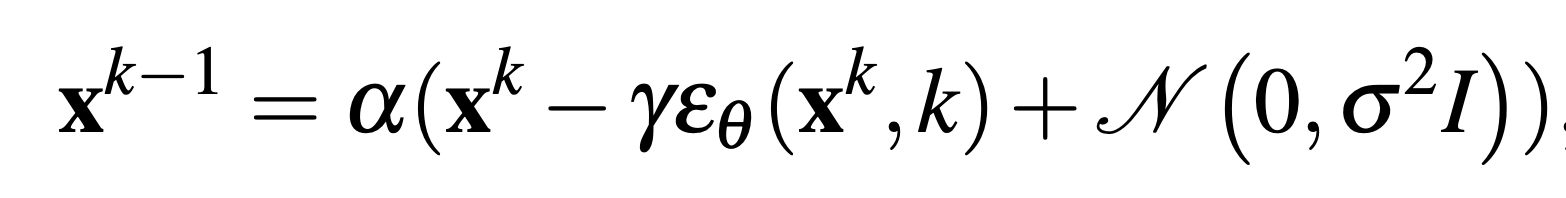

Within this equation, the $ε_{\theta}$ represents the noise prediction where Θ is the variable being optimized by learning and 𝒩(0, $σ^2$I) is the Gaussian noise that is being added at each iteration


2.   The noisy gradient step can also be represented through this equation

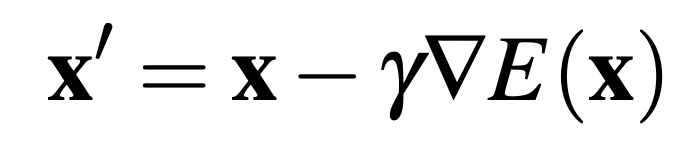


The  $ε_{\theta} (x,k)$ predicts the gradient field of E(x) and the learning rate is 𝒴




In [ ]:
from diffusers import DDPMScheduler, UNet1DModel

generator = torch.Generator(device='cuda')
generator_cpu = torch.Generator(device='cpu')
scheduler = DDPMScheduler(num_train_timesteps=100,beta_schedule="squaredcos_cap_v2")
network = UNet1DModel.from_pretrained("bglick13/hopper-medium-v2-value-function-hor32", subfolder="unet").to(device=DEVICE)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


unet/config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

An error occurred while trying to fetch bglick13/hopper-medium-v2-value-function-hor32: bglick13/hopper-medium-v2-value-function-hor32 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

The config attributes {'mid_block_layers': 1} were passed to UNet1DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
def reset_x0(x_in, cond, act_dim):
	for key, val in cond.items():
		x_in[:, key, act_dim:] = val.clone()
	return x_in

In [ ]:
obs = obs[None].repeat(n_samples, axis=0)
conditions = {
    0: to_torch(obs, device=DEVICE)
  }

batch_size = len(conditions[0])
shape = (batch_size, horizon, state_dim+action_dim)

In [ ]:
x1 = torch.randn(shape, device=DEVICE, generator=generator)
x = reset_x0(x1, conditions, action_dim)
x = to_torch(x)

In [ ]:
# noise
eta = 1.0

# run diffusion denoising
for i in tqdm.tqdm(scheduler.timesteps):

    timesteps = torch.full((batch_size,), i, device=DEVICE, dtype=torch.long)

    with torch.no_grad():
      residual = network(x.permute(0, 2, 1), timesteps).sample
      residual = residual.permute(0, 2, 1)
    obs_reconstruct = scheduler.step(residual, i, x)["prev_sample"]

    if eta > 0:
      noise = torch.randn(obs_reconstruct.shape, generator=generator_cpu).to(obs_reconstruct.device)
      posterior_variance = scheduler._get_variance(i) # * noise

      obs_reconstruct = obs_reconstruct + int(i>0) * (0.5 * posterior_variance) * eta* noise

    obs_reconstruct_postcond = reset_x0(obs_reconstruct, conditions, action_dim)
    x = to_torch(obs_reconstruct_postcond)

100%|██████████| 100/100 [00:02<00:00, 34.25it/s]


In [ ]:
import os
import mediapy as media

def to_np(x_in):
	if torch.is_tensor(x_in):
		x_in = x_in.detach().cpu().numpy()
	return x_in

def mkdir(savepath):
    """
        returns `True` iff `savepath` is created
    """
    if not os.path.exists(savepath):
        os.makedirs(savepath)
        return True
    else:
        return False


def show_sample(renderer, observations, filename='sample.mp4', savebase='/content/videos'):
    mkdir(savebase)
    savepath = os.path.join(savebase, filename)

    images = []
    for rollout in observations:
        img = renderer._renders(rollout, partial=True)
        images.append(img)

    images = np.concatenate(images, axis=2)
    media.show_video(images, codec='h264', fps=60)

In [ ]:
import mujoco_py as mjc

def env_map(env_name):
    if 'halfcheetah' in env_name:
        return 'HalfCheetahFullObs-v2'
    elif 'hopper' in env_name:
        return 'HopperFullObs-v2'
    elif 'walker2d' in env_name:
        return 'Walker2dFullObs-v2'
    else:
        return env_name

def get_image_mask(img):
    background = (img == 255).all(axis=-1, keepdims=True)
    mask = ~background.repeat(3, axis=-1)
    return mask

def atmost_2d(x):
    while x.ndim > 2:
        x = x.squeeze(0)
    return x

def set_state(env, state):
    qpos_dim = env.sim.data.qpos.size
    qvel_dim = env.sim.data.qvel.size
    if not state.size == qpos_dim + qvel_dim:
        warnings.warn(
            f'[ utils/rendering ] Expected state of size {qpos_dim + qvel_dim}, '
            f'but got state of size {state.size}')
        state = state[:qpos_dim + qvel_dim]

    env.set_state(state[:qpos_dim], state[qpos_dim:])

In [ ]:
class MuJoCoRenderer:
    def __init__(self, env):
        if type(env) is str:
            env = env_map(env)
            self.env = gym.make(env)
        else:
            self.env = env
        self.observation_dim = np.prod(self.env.observation_space.shape) - 1
        self.action_dim = np.prod(self.env.action_space.shape)
        try:
            self.viewer = mjc.MjRenderContextOffscreen(self.env.sim)
        except:
            print('[ utils/rendering ] Warning: could not initialize offscreen renderer')
            self.viewer = None

    def pad_observation(self, observation):
        state = np.concatenate([
            np.zeros(1),
            observation,
        ])
        return state

    def pad_observations(self, observations):
        qpos_dim = self.env.sim.data.qpos.size
        xvel_dim = qpos_dim - 1
        xvel = observations[:, xvel_dim]
        xpos = np.cumsum(xvel) * self.env.dt
        states = np.concatenate([
            xpos[:,None],
            observations,
        ], axis=-1)
        return states

    def render(self, observation, dim=256, partial=False, qvel=True, render_kwargs=None, conditions=None):

        if type(dim) == int:
            dim = (dim, dim)

        if self.viewer is None:
            return np.zeros((*dim, 3), np.uint8)

        if render_kwargs is None:
            xpos = observation[0] if not partial else 0
            render_kwargs = {
                'trackbodyid': 2,
                'distance': 3,
                'lookat': [xpos, -0.5, 1],
                'elevation': -20
            }

        for key, val in render_kwargs.items():
            if key == 'lookat':
                self.viewer.cam.lookat[:] = val[:]
            else:
                setattr(self.viewer.cam, key, val)

        if partial:
            state = self.pad_observation(observation)
        else:
            state = observation

        qpos_dim = self.env.sim.data.qpos.size
        if not qvel or state.shape[-1] == qpos_dim:
            qvel_dim = self.env.sim.data.qvel.size
            state = np.concatenate([state, np.zeros(qvel_dim)])

        set_state(self.env, state)

        self.viewer.render(*dim)
        data = self.viewer.read_pixels(*dim, depth=False)
        data = data[::-1, :, :]
        return data

    def _renders(self, observations, **kwargs):
        images = []
        for observation in observations:
            img = self.render(observation, **kwargs)
            images.append(img)
        return np.stack(images, axis=0)

    def renders(self, samples, partial=False, **kwargs):
        if partial:
            samples = self.pad_observations(samples)
            partial = False

        sample_images = self._renders(samples, partial=partial, **kwargs)

        composite = np.ones_like(sample_images[0]) * 255

        for img in sample_images:
            mask = get_image_mask(img)
            composite[mask] = img[mask]

        return composite

    def __call__(self, *args, **kwargs):
        return self.renders(*args, **kwargs)

render = MuJoCoRenderer(env)
de_normalized = de_normalize(to_np(x[:,:,action_dim:]), data, 'observations')
show_sample(render, de_normalized)

In [ ]:
from diffusers.experimental import ValueGuidedRLPipeline

env_name = "hopper-medium-v2"
env = gym.make(env_name)
data = env.get_dataset()
render = MuJoCoRenderer(env)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
DEVICE = "cuda"

pipeline = ValueGuidedRLPipeline.from_pretrained(
        "bglick13/hopper-medium-v2-value-function-hor32",
        env=env,
    )

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 21/21 [00:01<00:00, 11.60it/s]


model_index.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/246 [00:00<?, ?B/s]

pipeline.py:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

value_function/config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/9.23M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/9.23M [00:00<?, ?B/s]

The config attributes {'args': ['diffusers', 'DDPMScheduler'], 'kwargs': ['diffusers', 'PNDMScheduler']} were passed to ValueGuidedRLPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'args': ['diffusers', 'DDPMScheduler'], 'kwargs': ['diffusers', 'PNDMScheduler']} are not expected by ValueGuidedRLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--bglick13--hopper-medium-v2-value-function-hor32/snapshots/b3611b6c59c3088090d5a347f86562af7b815e1f/value_function: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--bglick13--hopper-medium-v2-value-function-hor32/snapshots/b3611b6c59c3088090d5a347f86562af7b815e1f/value_function.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'mid_block_layers': 1} were passed to UNet1DModel, but are not expected and will be ignored. Please verify your config.json configuration file.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--bglick13--hopper-medium-v2-value-function-hor32/snapshots/b3611b6c59c3088090d5a347f86562af7b815e1f/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--bglick13--hopper-medium-v2-valu

**Training Process Overview**

The training process starts with a random sample of $x^0$ examples from the dataset. We address each of the sample by getting a random denoising iteration k and then sampling a random noise $ᵋ^k$ with the right variance.   

In [ ]:
env.seed(0)
obs = env.reset()
total_reward = 0
total_score = 0
T = 100
rollout = [obs.copy()]
trajectories = []
y_maxes = [0]
for t in tqdm.tqdm(range(T)):
    denorm_actions = pipeline(obs, planning_horizon=32)
    next_observation, reward, terminal, _ = env.step(denorm_actions)
    score = env.get_normalized_score(total_reward)

    total_reward += reward
    total_score += score
    print(
        f"Step: {t}, Reward: {reward}, Total Reward: {total_reward}, Score: {score}, Total Score:"
        f" {total_score}"
    )
    rollout.append(next_observation.copy())
    obs = next_observation

show_sample(render, np.expand_dims(np.stack(rollout), axis=0))